In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import matplotlib
from sklearn.metrics import mean_squared_error
from math import sqrt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[RESELLER_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,2024.994,Southeast
1,2011-05-31,6074.982,Southeast
2,2011-05-31,2024.994,Southeast
3,2011-05-31,2039.994,Southeast
4,2011-05-31,2039.994,Southeast


In [6]:
dataset.shape

(60919, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60919 entries, 0 to 60918
Data columns (total 3 columns):
OrderDate         60919 non-null datetime64[ns]
Revenue           60919 non-null float64
Territory_Name    60919 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


# Time Series Modeling with Prophet
### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [88]:
dataset.tail()

,OrderDate,Revenue,Territory_Name
60914,2014-05-01,316.8600,Southwest
60915,2014-05-01,809.7600,Southwest
60916,2014-05-01,3274.8000,Southwest
60917,2014-05-01,97.1820,Southwest
60918,2014-05-01,203.3964,Southwest


In [89]:
dataset.groupby("Territory_Name").size()

Territory_Name
Australia          1713
Canada            11444
Central            5812
France             3530
Germany            1903
Northeast          5809
Northwest          7872
Southeast          5937
Southwest         13379
United Kingdom     3520
dtype: int64

In [90]:
GB = dataset.loc[dataset['Territory_Name'] == 'United Kingdom']
FR = dataset.loc[dataset['Territory_Name'] == 'France']
DE = dataset.loc[dataset['Territory_Name'] == 'Germany']
GB.shape, FR.shape, DE.shape

((3520, 3), (3530, 3), (1903, 3))

# Data Exploration
We are going to compare two Territory revenue in the same time period. This means combine two data frames into one and plot these two Territory’ time series into one plot.

In [91]:
GB['OrderDate'] =  pd.to_datetime(GB['OrderDate'], format='%Y/%m')
GB = GB.sort_values(by=['OrderDate'], ascending=[True])
GB.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

FR['OrderDate'] =  pd.to_datetime(FR['OrderDate'], format='%Y/%m')
FR = FR.sort_values(by=['OrderDate'], ascending=[True])
FR.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

DE['OrderDate'] =  pd.to_datetime(DE['OrderDate'], format='%Y/%m')
DE = DE.sort_values(by=['OrderDate'], ascending=[True])
DE.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

GB.drop(["Territory_Name"],axis=1, inplace=True)
FR.drop(["Territory_Name"],axis=1, inplace=True)
DE.drop(["Territory_Name"],axis=1, inplace=True)

In [92]:
#y = df.resample('MS').mean()
y_GB = GB.resample('MS').sum()
y_FR = FR.resample('MS').sum()
z_DE = DE.resample('MS').sum()

In [93]:
# filling up by mean value
y_GB = y_GB['Revenue'].replace(0.000000, y_GB['Revenue'].mean())
y_FR = y_FR['Revenue'].replace(0.000000, y_FR['Revenue'].mean())
z_DE = z_DE['Revenue'].replace(0.000000, z_DE['Revenue'].mean())

In [94]:
GB = pd.DataFrame({'OrderDate': y_GB.index, 'Revenue': y_GB.values})
FR = pd.DataFrame({'OrderDate': y_FR.index, 'Revenue': y_FR.values})
DE = pd.DataFrame({'OrderDate': z_DE.index, 'Revenue': z_DE.values})

In [95]:
store = GB.merge(FR,how='inner', on='OrderDate')
store.rename(columns={'Revenue_x': 'GB_revenue', 'Revenue_y': 'FR_revenue'}, inplace=True)
store.tail()

,OrderDate,GB_revenue,FR_revenue
20,2014-01-01,310841.686428,88275.467302
21,2014-02-01,171160.352983,184301.517305
22,2014-03-01,308662.326595,660006.847376
23,2014-04-01,171160.352983,184301.517305
24,2014-05-01,425979.108664,119236.299297


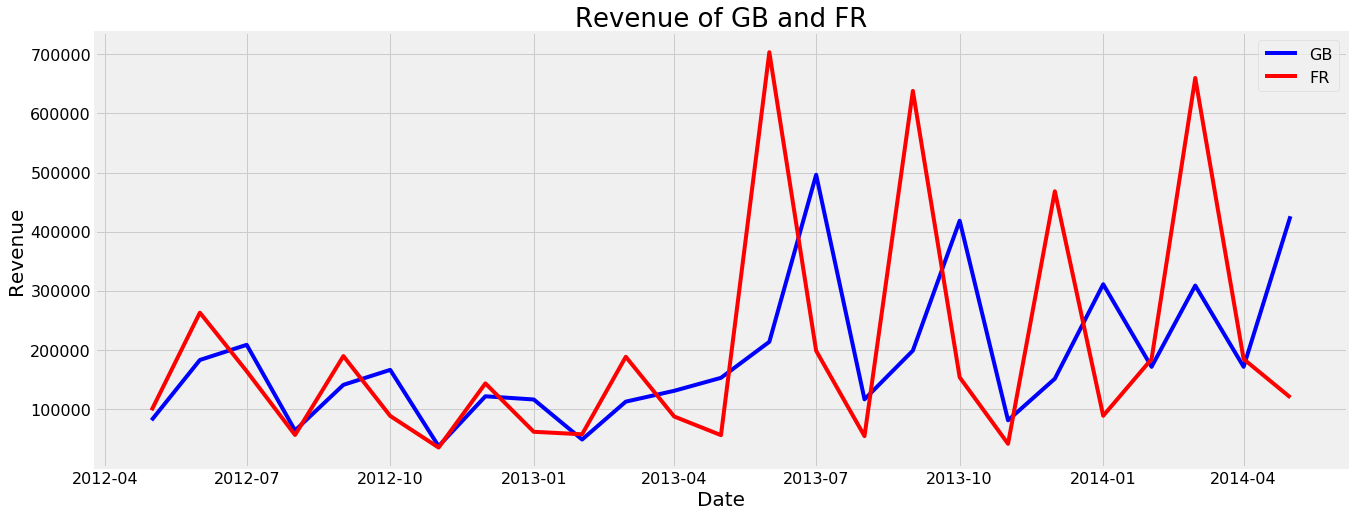

In [96]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['GB_revenue'], 'b-', label = 'GB')
plt.plot(store['OrderDate'], store['FR_revenue'], 'r-', label = 'FR')
plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Revenue of GB and FR')
plt.legend();

We observe that revenue of GB and FR shared one month different seasonal pattern. Early of the year is the off season for both of the two Territory. It seems end of summer time is quiet for both Territory. in addition, average monthly revenue for FR are higher than GB in most of the months. It is understandable, as the value of FR should be much higher than GB. Occasionally, GB passed revenue on average monthly revenue. Let’s find out when was the first time GB Revenue surpassed from FR.

# Fitt Model with Prophet

In [97]:
from fbprophet import Prophet
GB = GB.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
GB_model = Prophet(interval_width=0.95)
GB_model.fit(GB)

FR = FR.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
FR_model = Prophet(interval_width=0.95)
FR_model.fit(FR)

DE = DE.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
DE_model = Prophet(interval_width=0.95)
DE_model.fit(DE)

GB_forecast = GB_model.make_future_dataframe(periods=60, freq='MS')
GB_forecast = GB_model.predict(GB_forecast)

FR_forecast = FR_model.make_future_dataframe(periods=60, freq='MS')
FR_forecast = FR_model.predict(FR_forecast)

DE_forecast = DE_model.make_future_dataframe(periods=60, freq='MS')
DE_forecast = DE_model.predict(DE_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.


In [98]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

<Figure size 2016x864 with 0 Axes>

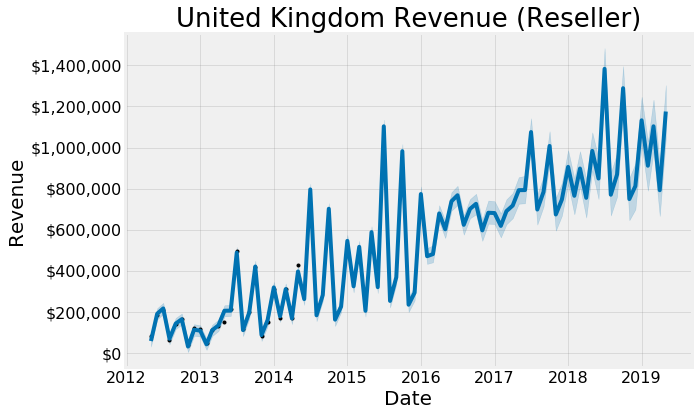

In [100]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
GB_model.plot(GB_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('United Kingdom Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

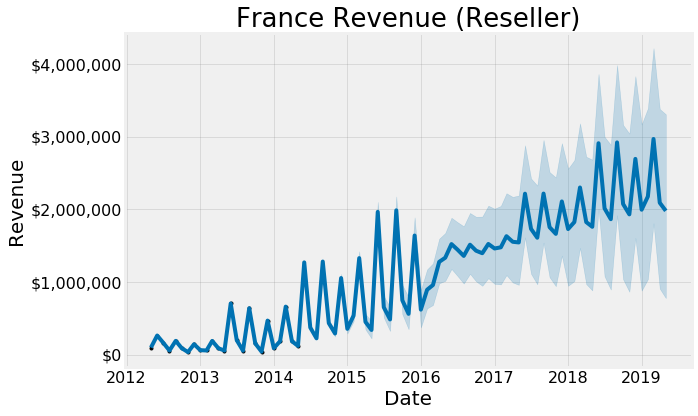

In [101]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
FR_model.plot(FR_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('France Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

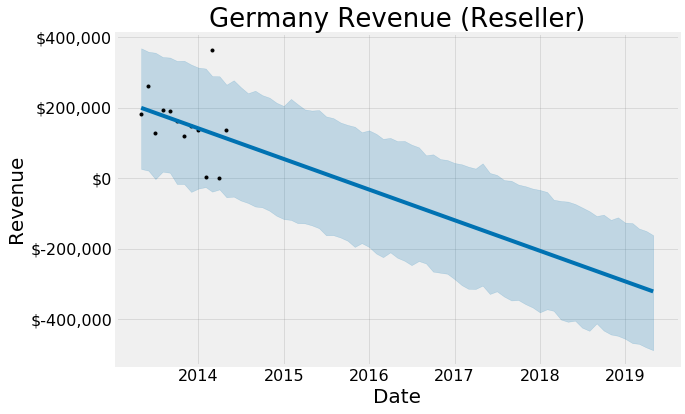

In [102]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
DE_model.plot(DE_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('Germany Revenue (Reseller)');

## Germany does not have enought previous revenue data there It can not be predict

# Compare Forecasts
We already have the forecasts for three years for these two Teritory into the future. We will now join them together to compare their future forecasts.

In [103]:
GB_names = ['GB_%s' % column for column in GB_forecast.columns]
FR_names = ['FR_%s' % column for column in FR_forecast.columns]
#DE_names = ['DE_%s' % column for column in DE_forecast.columns]

merge_GB_forecast = GB_forecast.copy()
merge_FR_forecast = FR_forecast.copy()
#merge_DE_forecast = DE_forecast.copy()

merge_GB_forecast.columns = GB_names
merge_FR_forecast.columns = FR_names
#merge_DE_forecast.columns = DE_names

forecast = pd.merge(merge_GB_forecast, merge_FR_forecast, how = 'inner', left_on = 'GB_ds', right_on = 'FR_ds')
forecast = forecast.rename(columns={'GB_ds': 'Date'}).drop('FR_ds', axis=1)
forecast.head()

,Date,GB_trend,GB_yhat_lower,GB_yhat_upper,GB_trend_lower,GB_trend_upper,GB_additive_terms,GB_additive_terms_lower,GB_additive_terms_upper,GB_yearly,...,FR_additive_terms,FR_additive_terms_lower,FR_additive_terms_upper,FR_yearly,FR_yearly_lower,FR_yearly_upper,FR_multiplicative_terms,FR_multiplicative_terms_lower,FR_multiplicative_terms_upper,FR_yhat
0,2012-05-01,18010.504093,30737.313151,84494.765864,18010.504093,18010.504093,39656.119350,39656.119350,39656.119350,39656.119350,...,95544.977003,95544.977003,95544.977003,95544.977003,95544.977003,95544.977003,0.0,0.0,0.0,97496.291625
1,2012-06-01,26805.628235,162782.407178,217443.719345,26805.628235,26805.628235,163784.325159,163784.325159,163784.325159,163784.325159,...,248885.213938,248885.213938,248885.213938,248885.213938,248885.213938,248885.213938,0.0,0.0,0.0,262815.129285
2,2012-07-01,35317.038790,189284.457124,243342.239746,35317.038790,35317.038790,181023.195825,181023.195825,181023.195825,181023.195825,...,138736.309636,138736.309636,138736.309636,138736.309636,138736.309636,138736.309636,0.0,0.0,0.0,163687.812450
3,2012-08-01,44112.162947,41616.943500,96117.648889,44112.162947,44112.162947,24511.732611,24511.732611,24511.732611,24511.732611,...,17480.481111,17480.481111,17480.481111,17480.481111,17480.481111,17480.481111,0.0,0.0,0.0,55789.731675
4,2012-09-01,52907.287074,116378.249253,170116.831688,52907.287074,52907.287074,89560.884891,89560.884891,89560.884891,89560.884891,...,137173.522932,137173.522932,137173.522932,137173.522932,137173.522932,137173.522932,0.0,0.0,0.0,189338.919900


# Trend and Forecast Visualization

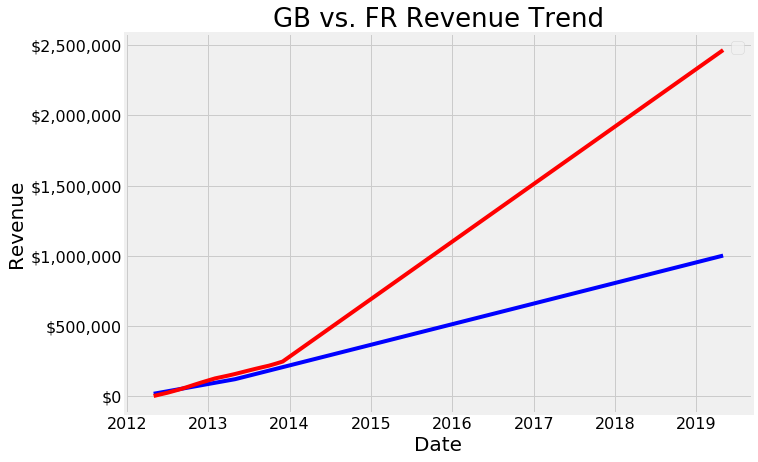

In [108]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['GB_trend'], 'b-')
plt.plot(forecast['Date'], forecast['FR_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("${x:,.0f}"))
plt.title('GB vs. FR Revenue Trend');


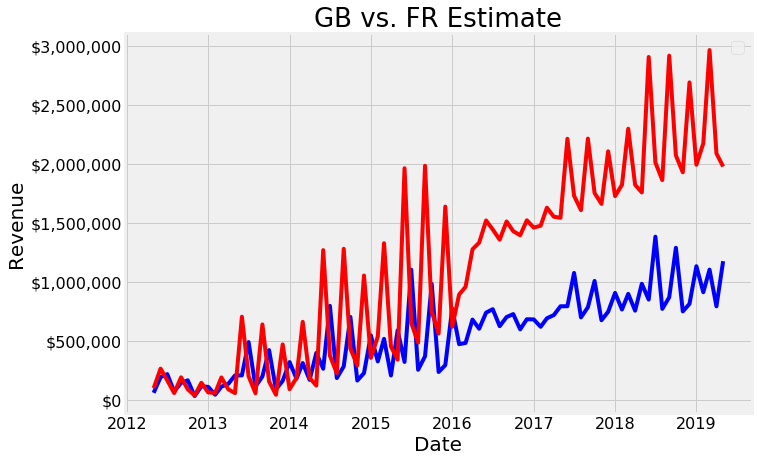

In [109]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['GB_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['FR_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("${x:,.0f}"))
plt.title('GB vs. FR Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

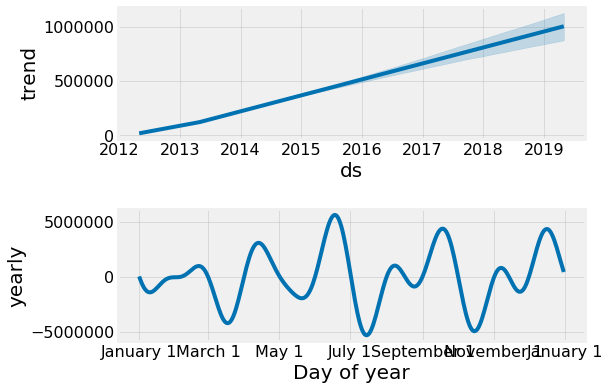

In [112]:
GB_model.plot_components(GB_forecast);

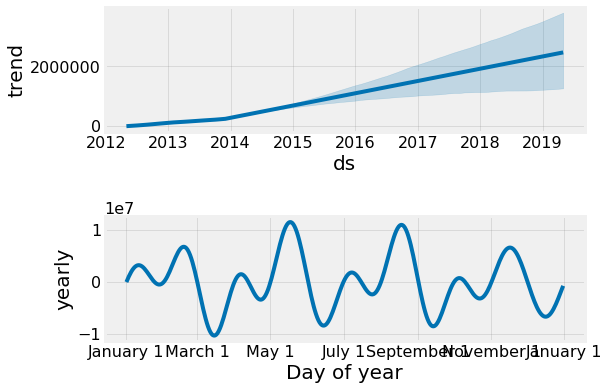

In [107]:
FR_model.plot_components(FR_forecast);

Good to see that the revenue for both GB and FR have been linearly increasing over time and will be keep growing, although FR’ growth seems strong.
The worst month for GB is April, the worst month for FR is February. The best month for GB is Auguest, and the best month for FR is Jan.
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.